<a href="https://colab.research.google.com/github/ramonfercruz/cotacao_saca_cafe_aribica/blob/main/avalia_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.3 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
DIRETORIO = '/content/drive/MyDrive/TCC/data/20230815'

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

In [ ]:
data_frame = pd.read_excel(os.path.join(DIRETORIO,'cotacao_cafe_inrriquecida.xlsx'))
data_frame = data_frame.query('ano >= 2010')
data_frame.set_index('Data', inplace=True)
data_frame.sort_index(  inplace=True)
data_frame['diesel'].fillna(method='ffill', inplace=True)

In [ ]:
def time_serie_train_test(index_train, index_teste, X, y):
  X_train = X.iloc[index_train,:]
  X_test = X.iloc[index_teste,:]
  y_train = y.iloc[index_train]
  y_test = y.iloc[index_teste]
  return X_train, y_train, X_test, y_test

def treina_modelo(model, i, X_train, y_train, X_test, y_test):
  y_train_predict = model.fit_predict(X_train, y_train)
  y_test_predict = model.predict(X_test, y_test)
  dict_metrica = {}
  dict_metrica['modelo'] = 'ARIMA'
  dict_metrica['rodada'] = i
  nome_metrica = 'mape'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_absolute_percentage_error, nome_metrica, dict_metrica)
  nome_metrica = 'mse'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_squared_error, nome_metrica, dict_metrica)
  nome_metrica = 'r2'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.r2_score, nome_metrica, dict_metrica)
  nome_metrica = 'mse_log'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_squared_log_error, nome_metrica, dict_metrica)
  nome_metrica = 'mae'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrics.mean_absolute_error, nome_metrica, dict_metrica)
  nome_metrica = 'rmse'
  dict_metrica = avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, root_mean_squared_error, nome_metrica, dict_metrica)
  return dict_metrica

def avalia_modelo_mestrica(y_train, y_train_predict, y_test, y_test_predict, metrica, nome_metrica, dict_metrica: dict):
    train_metrica = metrica(y_train, y_train_predict)
    test_metrica = metrica(y_test, y_test_predict)
    dict_metrica[f'{nome_metrica}_train'] = train_metrica
    dict_metrica[f'{nome_metrica}_test'] = test_metrica
    return dict_metrica
def root_mean_squared_error(y_true, y_predict):
  return metrics.mean_squared_error(y_true, y_predict, squared=False)

In [ ]:
class MeuSarima:
  def __init__(self, order, seasonal_order):
    self.order = order
    self.seasonal_order = seasonal_order
    self.modelo = None
    self.temp_model = None
    self.X_train = None

  def fit_predict(self, X, y):
    self.X_train = X
    self.y_train = y
    modelo_sarimax = sm.tsa.SARIMAX(endog=self.y_train, exog=self.X_train, order=self.order, seasonal_order=self.seasonal_order)
    self.modelo  = modelo_sarimax.fit()
    return self.modelo.predict()
  def predict(self, X, y):
    y_test = y
    X_train = X
    n_predict = y_test.shape[0]
    n_train = self.X_train.shape[0]
    X_temp = self.X_train
    y_temp = self.y_train
    lista_resultados = []
    for inicio, fim in enumerate(range(1, n_predict+ 1)):
      model_temp = sm.tsa.SARIMAX(endog=y_temp, exog=X_temp, order=self.order, seasonal_order=self.seasonal_order)
      model_temp = model_temp.filter(self.modelo.params)
      X_test_temp = X_test[inicio:fim]
      y_test_temp =  y_test[inicio:fim]
      resultado = model_temp.predict(start=n_train, exog=X_test_temp)
      lista_resultados.append(resultado)
      X_temp = pd.concat([X_temp,X_test_temp ])
      y_temp = pd.concat([y_temp,y_test_temp ])
      n_train = n_train + 1
    y_predict = pd.concat(lista_resultados)
    return y_predict
  def predict_train(self):
    return self.modelo.predict()

In [ ]:
split_time_serie = TimeSeriesSplit(n_splits=5, test_size=10)

In [ ]:
data_frame.columns

Index(['dolar', 'cafe_aribica', 'indices_preco_produtos', 'cafe_robusta',
       'ano', 'mes', 'mes.1', 'INDICE', 'IPCA_MES', '3_MESES', 'IPCA_6_MESES',
       'IPCA_ANO', '12_MESES', 'diesel', 'cafe_aribica_dif',
       'cafe_aribica_mov_quadrimestre', 'cafe_aribica_mov_semestre',
       'cafe_aribica_mov_anual', 'data_real', 'estacao_ano', 'inverno',
       'outono', 'primavera', 'verao', 'April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September'],
      dtype='object')

In [ ]:
X = data_frame[['dolar', 'diesel', '12_MESES']]
y = data_frame['cafe_aribica']



In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
metricas = []
for i, (index_train, index_teste) in enumerate(split_time_serie.split(X)):
  X_train, y_train, X_test, y_test = time_serie_train_test(index_train, index_teste, X, y)
  arima = MeuSarima(order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
  metricas.append(treina_modelo(arima, i, X_train, y_train, X_test, y_test))

In [ ]:
df_metrica = pd.DataFrame(metricas)
df_metrica

,modelo,rodada,mape_train,mape_test,mse_train,mse_test,r2_train,r2_test,mse_log_train,mse_log_test,mae_train,mae_test,rmse_train,rmse_test
0,ARIMA,0,0.044952,0.072655,881.984348,1919.625272,0.842032,0.280694,0.018774,0.007895,17.927851,35.429757,29.698221,43.813528
1,ARIMA,1,0.048807,0.067553,1036.637654,1754.835294,0.812373,0.026398,0.027114,0.005977,19.876453,37.039864,32.196858,41.890754
2,ARIMA,2,0.049293,0.058675,935.668425,4751.739768,0.859603,0.893309,0.011778,0.004777,20.916384,58.354615,30.588698,68.932864
3,ARIMA,3,0.046259,0.039947,862.808730,8153.709340,0.967389,-0.095265,0.003606,0.004146,21.810073,52.651548,29.373606,90.297892
4,ARIMA,4,0.051429,0.081946,1494.641973,8811.483614,0.979401,0.043288,0.018419,0.007847,25.472763,83.849936,38.660600,93.869503


In [ ]:
df_metrica.to_csv(os.path.join(DIRETORIO, 'metricas_sarimax.csv'), sep=';', decimal=',')

In [ ]:
df_metrica_final_group = df_metrica.groupby(['modelo']).agg(media_mape_test=('mape_test', 'mean'),
                                          #media_mape_train=('mape_train', 'mean'),
                                          media_mse_test=('mse_test', 'mean'),
                                          #media_mse_train=('mse_train', 'mean'),
                                          media_r2_test=('r2_test', 'mean'),
                                          #media_r2_train=('r2_train', 'mean'),
                                          media_mse_log_test=('mse_log_test', 'mean'),
                                          #media_mse_log_train=('mse_log_train', 'mean'),
                                          media_mae_test=('mae_test', 'mean'),
                                          media_rmse_test=('rmse_test', 'mean'),
                                         )
df_metrica_final_group

,media_mape_test,media_mse_test,media_r2_test,media_mse_log_test,media_mae_test,media_rmse_test
modelo,,,,,,
ARIMA,0.064155,5078.278657,0.229685,0.006128,53.465144,67.760908


In [ ]:
data_frame

,dolar,cafe_aribica,indices_preco_produtos,cafe_robusta,ano,mes,mes.1,INDICE,IPCA_MES,3_MESES,...,December,February,January,July,June,March,May,November,October,September
Data,,,,,,,,,,,,,,,,,,,,,
2010-01-01,1.78,280.75,191.1,173.69,2010.0,1.0,JAN,3040.22,0.75,1.54,...,0,0,1,0,0,0,0,0,0,0
2010-02-01,1.84,278.68,175.7,168.47,2010.0,2.0,FEV,3063.93,0.78,1.91,...,0,1,0,0,0,0,0,0,0,0
2010-03-01,1.79,279.70,170.2,173.99,2010.0,3.0,MAR,3079.86,0.52,2.06,...,0,0,0,0,0,1,0,0,0,0
2010-04-01,1.76,282.18,171.7,158.23,2010.0,4.0,ABR,3097.42,0.57,1.88,...,0,0,0,0,0,0,0,0,0,0
2010-05-01,1.82,289.46,175.6,160.51,2010.0,5.0,MAI,3110.74,0.43,1.53,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,5.20,1104.68,688.3,646.30,2023.0,3.0,MAR,6609.67,0.71,2.09,...,0,0,0,0,0,1,0,0,0,0
2023-04-01,5.02,1106.36,618.1,663.93,2023.0,4.0,ABR,6649.99,0.61,2.18,...,0,0,0,0,0,0,0,0,0,0
2023-05-01,4.98,1039.88,552.1,678.52,2023.0,5.0,MAI,6665.28,0.23,1.56,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
X_data

,dolar,diesel,INDICE
Data,,,
2010-01-01,1.78,2.001532,3040.22
2010-02-01,1.84,2.008321,3063.93
2010-03-01,1.79,2.008185,3079.86
2010-04-01,1.76,2.006729,3097.42
2010-05-01,1.82,2.006144,3110.74
...,...,...,...
2022-05-01,4.95,6.867940,6412.88
2022-06-01,5.06,7.231846,6455.85
2022-07-01,5.37,7.490087,6411.95


In [ ]:
import pmdarima
from pmdarima.arima import ARIMA

In [ ]:
data = data_frame[:-10]
y_data = data['cafe_aribica']
X_data  = data[['dolar', 'diesel', 'INDICE']]

In [ ]:
#arima_model = ARIMA(order=(1, 1, 0), seasonal_order=(2, 1, 0, 12))

arima_model = ARIMA(order=(1, 1, 0))
arima_model.fit(X=X_data, y=y_data, information_criterion='aic', maxiter=100)

ARIMA(order=(1, 1, 0))

In [ ]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  153
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -750.410
Date:                Wed, 13 Sep 2023   AIC                           1512.820
Time:                        01:15:05   BIC                           1530.963
Sample:                    01-01-2010   HQIC                          1520.190
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0666      4.731     -0.437      0.662     -11.339       7.206
dolar         58.1656     17.389      3.345      0.001      24.084      92.247
diesel       -59.8227     23.506     -2.545      0.0

In [ ]:
arima_model.resid()

Data
2010-01-01   -1130.444206
2010-02-01     -12.737437
2010-03-01       3.906648
2010-04-01      -0.870816
2010-05-01       0.923817
                 ...     
2022-05-01      11.777117
2022-06-01      69.470805
2022-07-01     -16.350306
2022-08-01     -13.484052
2022-09-01      -8.310093
Length: 153, dtype: float64

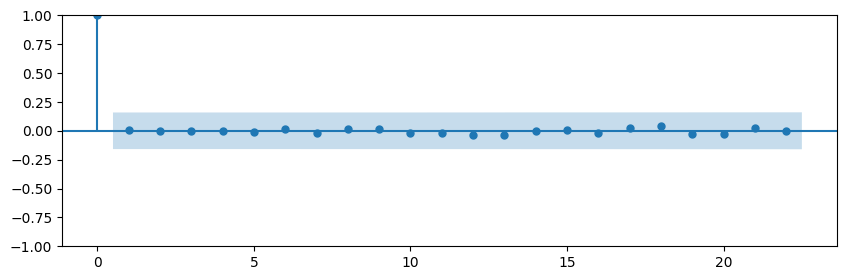

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(111)
ax = plot_acf(arima_model.resid(), ax=ax1, title='')

<Figure size 1000x2000 with 0 Axes>

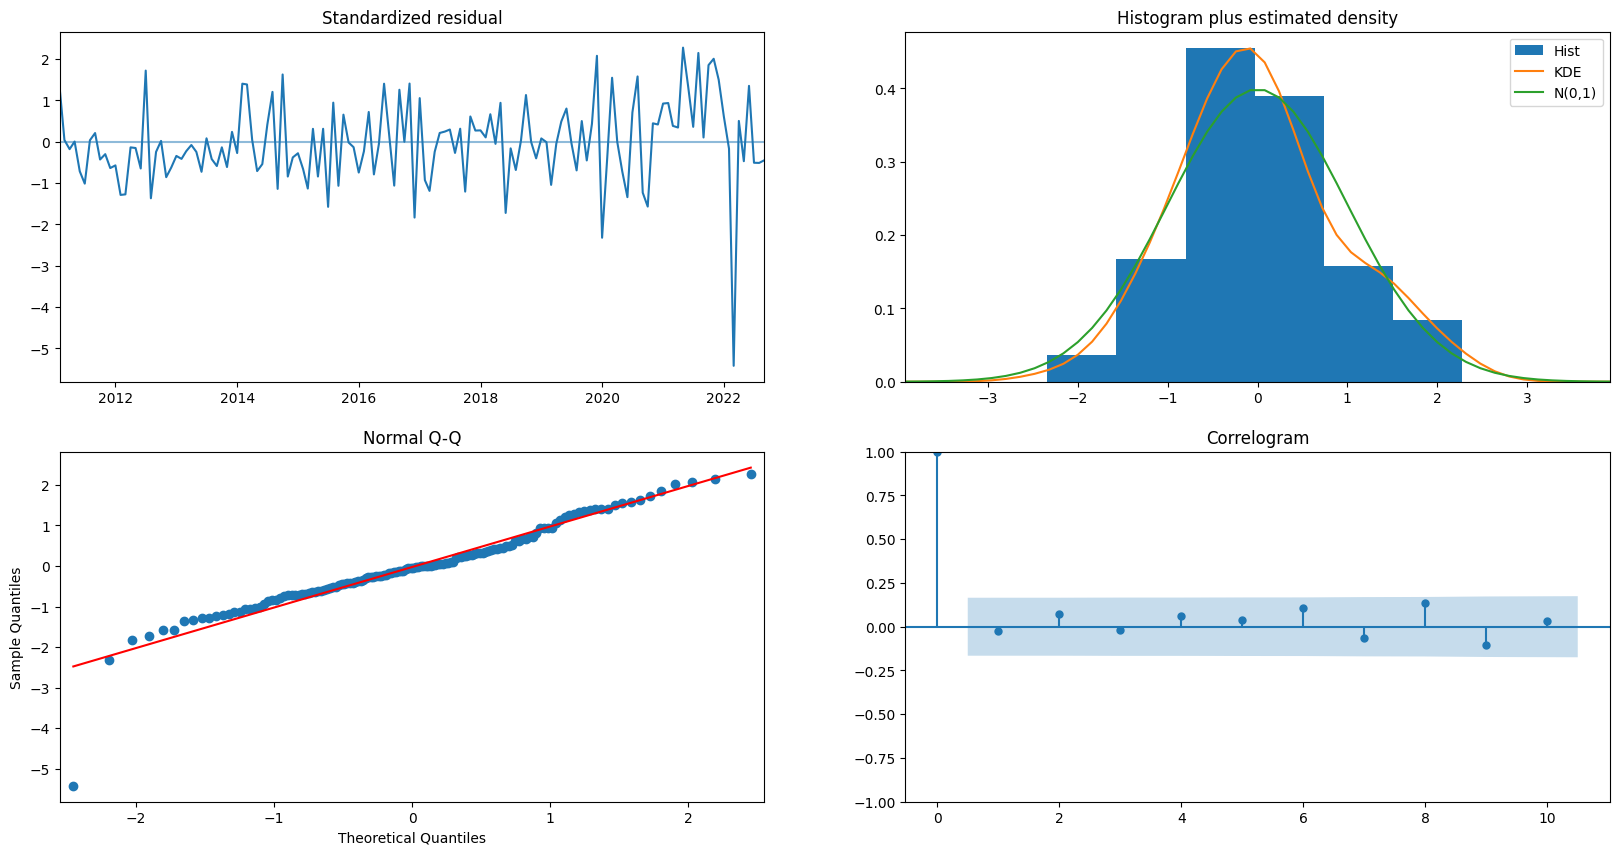

In [ ]:
plt.figure(figsize=(10,20))
arima_model.plot_diagnostics(figsize=(20,10));

In [ ]:
df_metrica_final_group.to_csv(os.path.join(DIRETORIO, 'agg_metricas_sarimax.csv'), sep=';', decimal=',')

In [ ]:
pip install pmdarima

In [ ]:
sarimax_model = sm.tsa.SARIMAX(endog=y_data, exog=X_data, order=(1, 1, 0), seasonal_order=(2, 1, 0, 6))
sarimax_model_fit = sarimax_model.fit()

In [ ]:
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      cafe_aribica   No. Observations:                  153
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 6)   Log Likelihood                -736.101
Date:                           Tue, 12 Sep 2023   AIC                           1486.203
Time:                                   00:57:30   BIC                           1507.088
Sample:                               01-01-2010   HQIC                          1494.689
                                    - 09-01-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dolar         66.0363     16.348      4.039      0.000      33.995      98.078
diesel       -78.4660     22.174     -3.539

In [ ]:
sarimax_model_fit.params

dolar         55.172248
diesel       -31.248151
ar.L1          0.361788
ar.S.L6       -0.612894
ar.S.L12      -0.393613
sigma2      1461.925210
dtype: float64

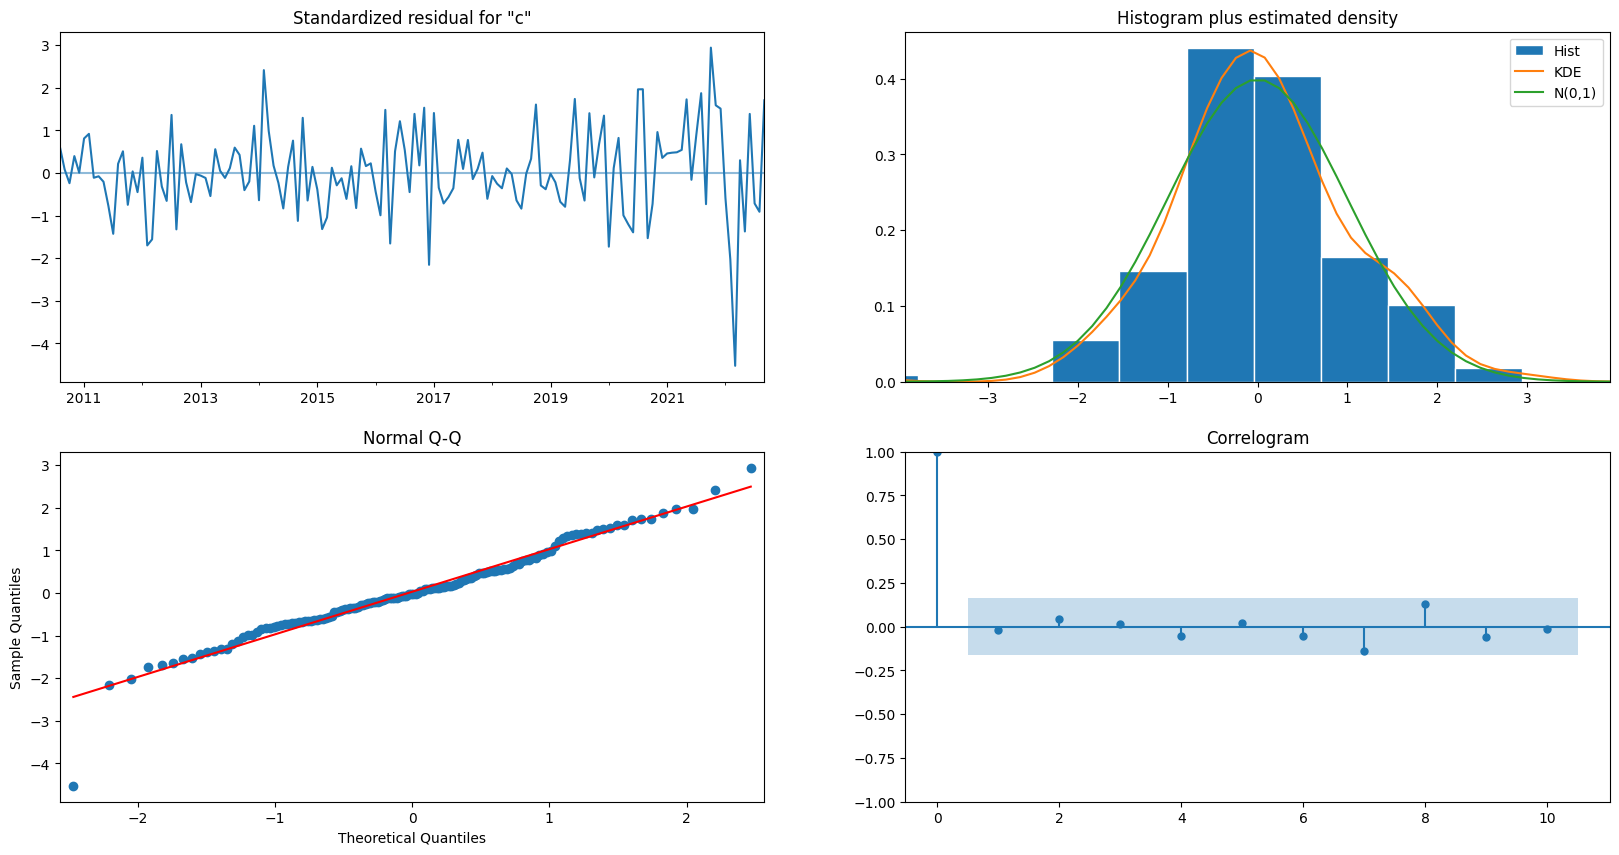

In [ ]:
sarimax_model_fit.plot_diagnostics(figsize=(20,10));

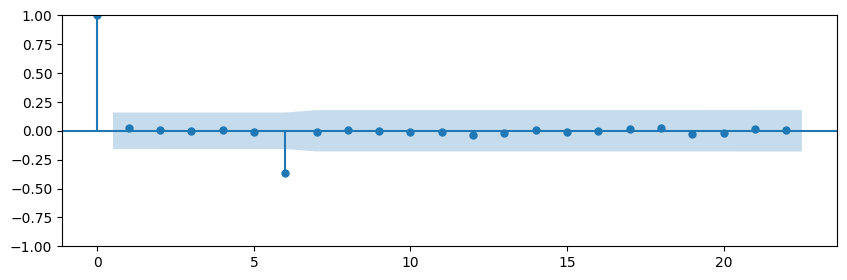

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(111)
ax = plot_acf(sarimax_model_fit.resid, ax=ax1, title='')

In [ ]:
rediduos = sarimax_model_fit.resid
rediduos

Data
2010-01-01    228.172308
2010-02-01     -6.636054
2010-03-01      2.333839
2010-04-01      3.772325
2010-05-01      3.887501
                 ...    
2022-05-01    -77.593293
2022-06-01     43.520267
2022-07-01    -63.426023
2022-08-01    -53.400974
2022-09-01     82.136344
Length: 153, dtype: float64

In [ ]:
rediduos.describe()

count    153.000000
mean       1.609440
std       45.161548
min     -192.565080
25%      -18.389273
50%        3.071051
75%       21.769089
max      228.172308
dtype: float64

In [ ]:
rediduos.sort_values()

Data
2022-03-01   -192.565080
2010-07-01   -114.185417
2020-06-01    -96.203311
2016-12-01    -87.622021
2020-01-01    -81.759065
                 ...    
2021-05-01     81.629425
2022-09-01     82.136344
2020-07-01     88.644037
2021-10-01    126.778372
2010-01-01    228.172308
Length: 153, dtype: float64

<Axes: ylabel='Count'>

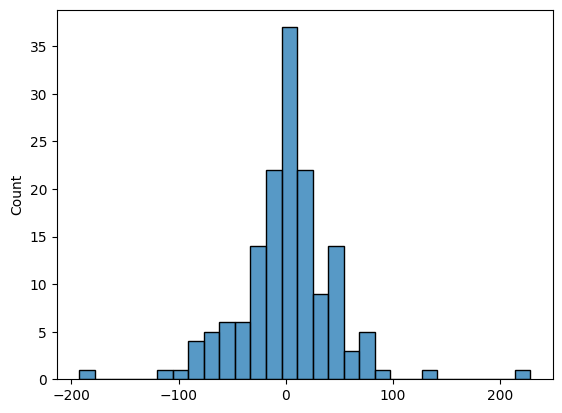

In [ ]:
sns.histplot(rediduos)

In [ ]:
from statsmodels.stats.stattools import jarque_bera

redultado = jarque_bera(rediduos)

In [ ]:

redultado

(191.63638604360827,
 2.4360573297376582e-42,
 0.23845671269056826,
 8.461974291422397)

In [ ]:
print(' '*254)
print('Estatística Jarque-Bera :', redultado[0])
print('P-valor :', redultado[1])
print('Assimetria :', redultado[2])
print('Curtose :',redultado[3])

                                                                                                                                                                                                                                                              
Estatística Jarque-Bera : 667.2580250002668
P-valor : 1.2786770439200552e-145
Assimetria : 1.2503932597038356
Curtose : 12.920382667749607


In [ ]:
scaler_y = None
def reshape_y(y, scaler_y):
  return y

In [ ]:
y_train_predict = arima.predict_train()
y_pred = arima.predict( X_test, y_test)
scaler_y = None
test_y = y_test

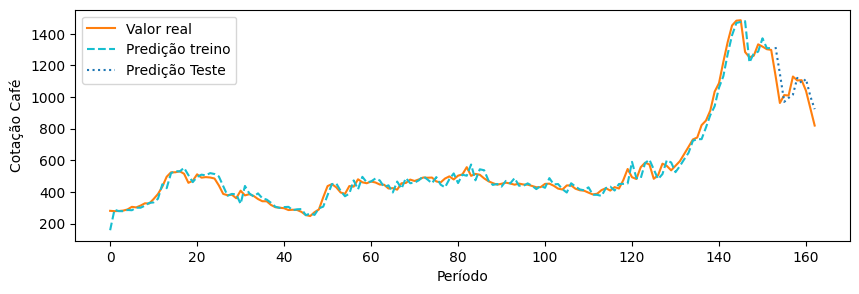

In [ ]:
compara_treino_teste(y, y_train_predict, y_pred, scaler_y, test_y)

In [ ]:
def compara_treino_teste(y, y_train_predict, y_pred, scaler_y, test_y):
    train_size = len(y_train_predict)
    y_size = len(y)
    test_size = len(test_y)

    plt.figure(figsize=(10, 3))
    ax = sns.lineplot(y=y, x=range(y_size), color='#ff7f0e',label='Valor real')
    ax1 = sns.lineplot(y=reshape_y(y_train_predict, scaler_y), x=range(train_size), linestyle='--', color='#17becf', label='Predição treino')
    ax2 = sns.lineplot(y=reshape_y(y_pred, scaler_y), x=range(train_size, train_size + test_size), linestyle=':', color='#1f77b4',label='Predição Teste')
    ax.set_ylabel('Cotação Café')
    ax.set_xlabel('Período')

In [ ]:
X_train.shape

(113, 3)

In [ ]:
y.shape[0]

163

In [ ]:
n_train = X_train.shape[0]

In [ ]:
n_predict = y_test.shape[0]
n_train = X_train.shape[0]
X_temp = X_train
y_temp = y_train
lista_resultados = []
for inicio, fim in enumerate(range(1, n_predict+ 1)):
  model_temp = sm.tsa.SARIMAX(endog=y_temp, exog=X_temp, order=(1, 1, 0), seasonal_order=(2, 1, 0, 12), freq='MS')
  model_temp = model_temp.filter(modelo_fit.params)
  X_test_temp = X_test[inicio:fim]
  y_test_temp =  y_test[inicio:fim]
  resultado = model_temp.predict(start=n_train, exog=X_test_temp)
  lista_resultados.append(resultado)
  X_temp = pd.concat([X_temp,X_test_temp ])
  y_temp = pd.concat([y_temp,y_test_temp ])
  n_train = n_train + 1
y_predict = pd.concat(lista_resultados)

In [ ]:
def compara_treino_teste(y, y_train_predict, y_pred, scaler_y):
    train_size = len(y_train_predict)
    y_size = len(y)
    test_size = len(test_y)

    plt.figure(figsize=(10, 3))
    ax = sns.lineplot(y=reshape_y(y, scaler_y), x=range(y_size), color='#ff7f0e',label='Valor real')
    ax1 = sns.lineplot(y=reshape_y(y_train_predict, scaler_y), x=range(train_size), linestyle='--', color='#17becf', label='Predição treino')
    ax2 = sns.lineplot(y=reshape_y(y_pred, scaler_y), x=range(train_size, train_size + test_size), linestyle=':', color='#1f77b4',label='Predição Teste')
    ax.set_ylabel('Cotação Café')
    ax.set_xlabel('Período')

In [ ]:
compara_treino_teste(y, y_train_predict, y_pred, scaler_y)

                                     SARIMAX Results                                      
Dep. Variable:                       cafe_aribica   No. Observations:                  113
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -474.913
Date:                            Sun, 10 Sep 2023   AIC                            963.827
Time:                                    20:29:19   BIC                            982.063
Sample:                                01-01-2010   HQIC                           971.207
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dolar         14.2131     29.763      0.478      0.633     -44.121      72.547
diesel         0.8745     78.108   

In [ ]:
pd.concat(lista_resultados)

2019-06-01    394.185151
2019-07-01    416.593092
2019-08-01    414.357441
2019-09-01    415.710279
2019-10-01    445.856934
2019-11-01    444.580722
2019-12-01    446.399817
2020-01-01    564.567115
2020-02-01    483.776175
2020-03-01    468.794896
Freq: MS, dtype: float64

In [ ]:
resultado

2019-06-01    394.185151
2019-07-01    416.593092
2019-08-01    414.357441
2019-09-01    415.710279
2019-10-01    445.856934
2019-11-01    444.580722
2019-12-01    446.399817
2020-01-01    564.567115
2020-02-01    483.776175
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
y_test

Data
2019-06-01    411.94
2019-07-01    423.67
2019-08-01    408.74
2019-09-01    430.63
2019-10-01    421.59
2019-11-01    475.11
2019-12-01    545.17
2020-01-01    493.03
2020-02-01    481.91
2020-03-01    556.28
Name: cafe_aribica, dtype: float64

In [ ]:
X_test_temp

,dolar,diesel,12_MESES
Data,,,
2019-06-01,3.86,3.622075,3.37


In [ ]:
y_temp


Data
2010-01-01    280.75
2010-02-01    278.68
2010-03-01    279.70
2010-04-01    282.18
2010-05-01    289.46
               ...  
2019-01-01    410.87
2019-02-01    407.70
2019-03-01    395.61
2019-04-01    384.35
2019-05-01    389.04
Name: cafe_aribica, Length: 113, dtype: float64

In [ ]:
resultado

2019-06-01    394.185151
Freq: MS, dtype: float64

In [ ]:
modelo_fit.predict(start=113, exog=X_test[:1])

2019-06-01    394.185151
Freq: MS, dtype: float64

In [ ]:
y_train

Data
2010-01-01    280.75
2010-02-01    278.68
2010-03-01    279.70
2010-04-01    282.18
2010-05-01    289.46
               ...  
2019-01-01    410.87
2019-02-01    407.70
2019-03-01    395.61
2019-04-01    384.35
2019-05-01    389.04
Name: cafe_aribica, Length: 113, dtype: float64

In [ ]:
y_test

array([411.94, 423.67, 408.74, 430.63, 421.59, 475.11, 545.17, 493.03,
       481.91, 556.28])